In [1]:
import ast
import pyspark
import operator
import numpy as np
import matplotlib.pyplot as plt
from operator import add
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import col,split,explode,array_contains


In [2]:
conf = SparkConf().setMaster("local[*]").setAppName("lab6")
sc = SparkContext(conf=conf)
sqlContext = pyspark.SQLContext(sc)

In [3]:
#Loading the Dataset
data = sqlContext.read.json("E:/RAAM/GSU MSA/yelp.json")

print(data.first())
print(data.count())

Row(address='10913 Bailey Rd', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2='3', RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='f9NumwFMBDn751xgFiRbNA', categories='Active Life,

In [4]:
data.first()['categories']

'Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping'

In [5]:
df=data.collect()
df[0:2]

[Row(address='10913 Bailey Rd', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2='3', RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='f9NumwFMBDn751xgFiRbNA', categories='Active Life

In [6]:
#Filter Businesses with stars more than 3.5 and where categories is not Null
data=data.filter(data['stars']>=3.5)
data=data.filter("categories is not Null")
data.collect()[0:2]

[Row(address='10913 Bailey Rd', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2='3', RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='f9NumwFMBDn751xgFiRbNA', categories='Active Life

In [7]:
def get_keyval(row):
 
    # get the text from the row entry
    cat=row.categories
    if cat is None:
        return [['None',1]]
    #lower case text and split by space to get the words
    words=cat.split(",")
 
    #for each word, send back a count of 1
    #send a list of lists
    return [[w.strip(), 1] for w in words]
 

In [8]:
sum_all = data.rdd.flatMap(lambda x:get_keyval(x))
counts_rdd = sum_all.reduceByKey(add)
word_count = counts_rdd.collect ()

In [9]:
type(word_count[0])

tuple

In [10]:
word_count.sort(key=operator.itemgetter(1),reverse=True)

In [11]:
word_count[0:10]

[('Restaurants', 40216),
 ('Food', 22417),
 ('Shopping', 21915),
 ('Beauty & Spas', 14675),
 ('Home Services', 13391),
 ('Health & Medical', 12833),
 ('Local Services', 10293),
 ('Nightlife', 9578),
 ('Automotive', 8706),
 ('Bars', 8396)]

In [12]:
def attribute_count(row):
 
    # get the text from the row entry
    row=row['attributes']
    super_list=[]
    if row is not None:
        row=row.asDict()
        for i in row:
            if row[i] is not None and row[i]!='False':
                if '{' in row[i]:
                    sub_dict=ast.literal_eval(row[i])
                    sub_list=[[(j,sub_dict[j]),1] for j in sub_dict if sub_dict[j] is not None and sub_dict[j]!='False' and sub_dict[j]!=False]
                    super_list=super_list+sub_list
                else:
                    super_list.append([(i,row[i]),1])
    if len(super_list)==0:
        super_list=[[('No_attribute','None'),1]]
                    
    return super_list
 

In [13]:
def processing_list(x):
    splitlist=x.split(',')
    return [i.strip() for i in splitlist]


In [14]:
udfValueToCategory = udf(processing_list, ArrayType(StringType()))
data = data.withColumn("categories", udfValueToCategory("categories"))


In [15]:
data.collect()[0:2]

[Row(address='10913 Bailey Rd', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2='3', RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='f9NumwFMBDn751xgFiRbNA', categories=['Active Lif

In [16]:
def filtered_data_processing(category):
    filtered_data=data.filter(array_contains(data['categories'],category))
    print(len(filtered_data.collect()))
    sum_all_attributes = filtered_data.rdd.flatMap(lambda x:attribute_count(x))
    counts_rdd_attributes = sum_all_attributes.reduceByKey(add)
    word_count_attributes = counts_rdd_attributes.collect()
    word_count_attributes.sort(key=operator.itemgetter(1),reverse=True)
    return word_count_attributes

In [17]:
def bar_graph(word_count_attributes):
    plt.figure(figsize=(5,5))
    top_attrs=[]
    for i in range(0,10):
        if word_count_attributes[i][0][1]!=True and word_count_attributes[i][0][1]!='True':
            top_attrs.append(word_count_attributes[i][0][0]+' - '+word_count_attributes[i][0][1])
        else:
            top_attrs.append(word_count_attributes[i][0][0])
    height = [i[1] for i in word_count_attributes[0:10]]
    bars = tuple(top_attrs)
    y_pos = np.arange(len(bars))
 
    # Create bars
    plt.barh(y_pos, height)
 
    # Create names on the x-axis
    plt.yticks(y_pos, bars)
 
    # Show graphic
    plt.show()



In [18]:
#Restaurants
word_count_attributes_restaurants=filtered_data_processing('Restaurants')
word_count_attributes_restaurants[0:10]

40216


[(('RestaurantsTakeOut', 'True'), 32791),
 (('RestaurantsGoodForGroups', 'True'), 28635),
 (('GoodForKids', 'True'), 27067),
 (('HasTV', 'True'), 23284),
 (('BusinessAcceptsCreditCards', 'True'), 22279),
 (('BikeParking', 'True'), 21379),
 (('RestaurantsPriceRange2', '2'), 18982),
 (('RestaurantsAttire', "u'casual'"), 17896),
 (('NoiseLevel', "u'average'"), 15634),
 (('lot', True), 15337)]

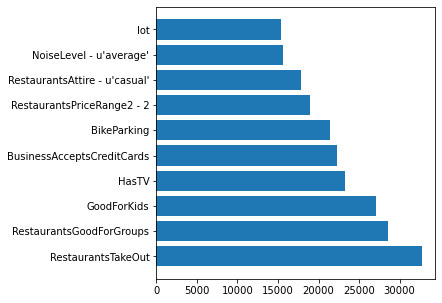

In [19]:
bar_graph(word_count_attributes_restaurants)

In [20]:
#Food
word_count_attributes_food=filtered_data_processing('Food')
word_count_attributes_food[0:10]

22417


[(('RestaurantsTakeOut', 'True'), 15217),
 (('BikeParking', 'True'), 13173),
 (('BusinessAcceptsCreditCards', 'True'), 13067),
 (('RestaurantsPriceRange2', '2'), 9764),
 (('lot', True), 8476),
 (('RestaurantsPriceRange2', '1'), 8347),
 (('GoodForKids', 'True'), 8086),
 (('RestaurantsGoodForGroups', 'True'), 7126),
 (('Caters', 'True'), 6497),
 (('OutdoorSeating', 'True'), 6082)]

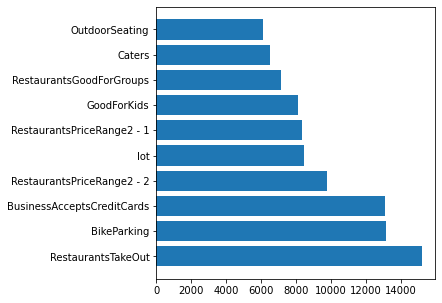

In [21]:
bar_graph(word_count_attributes_food)

In [22]:
#Shopping
word_count_attributes_shopping=filtered_data_processing('Shopping')
word_count_attributes_shopping[0:10]

21915


[(('BusinessAcceptsCreditCards', 'True'), 15550),
 (('BikeParking', 'True'), 11181),
 (('RestaurantsPriceRange2', '2'), 10271),
 (('lot', True), 7346),
 (('WheelchairAccessible', 'True'), 4591),
 (('street', True), 3268),
 (('RestaurantsPriceRange2', '3'), 2772),
 (('RestaurantsPriceRange2', '1'), 2642),
 (('ByAppointmentOnly', 'True'), 1818),
 (('DogsAllowed', 'True'), 1544)]

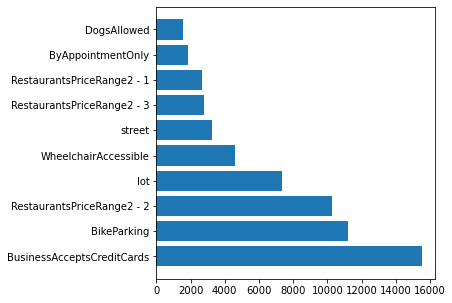

In [23]:
bar_graph(word_count_attributes_shopping)

In [24]:
#Beauty & Spas
word_count_attributes_beauty=filtered_data_processing('Beauty & Spas')
word_count_attributes_beauty[0:10]

14675


[(('BusinessAcceptsCreditCards', 'True'), 10472),
 (('BikeParking', 'True'), 8728),
 (('RestaurantsPriceRange2', '2'), 8459),
 (('ByAppointmentOnly', 'True'), 6111),
 (('lot', True), 5693),
 (('WheelchairAccessible', 'True'), 4529),
 (('WiFi', "u'free'"), 3664),
 (('GoodForKids', 'True'), 3244),
 (('street', True), 2557),
 (('RestaurantsPriceRange2', '1'), 1755)]

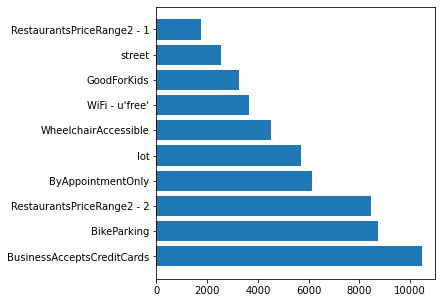

In [25]:
bar_graph(word_count_attributes_beauty)

In [26]:
#Home Services
word_count_attributes_home=filtered_data_processing('Home Services')
word_count_attributes_home[0:10]

13391


[(('BusinessAcceptsCreditCards', 'True'), 9388),
 (('ByAppointmentOnly', 'True'), 4828),
 (('No_attribute', 'None'), 2711),
 (('BikeParking', 'True'), 942),
 (('RestaurantsPriceRange2', '2'), 770),
 (('WheelchairAccessible', 'True'), 712),
 (('lot', True), 686),
 (('WiFi', "u'free'"), 263),
 (('DogsAllowed', 'True'), 242),
 (('RestaurantsPriceRange2', '3'), 214)]

In [27]:
del word_count_attributes_home[2]

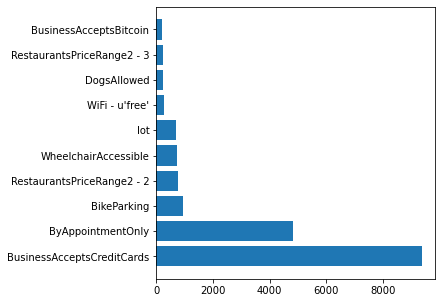

In [28]:
bar_graph(word_count_attributes_home)